In [1]:
import numpy as np, pandas as pd 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import warnings
import gc
import copy
from itertools import product
from IPython.display import display
from IPython.display import set_matplotlib_formats
import datetime
set_matplotlib_formats('svg')

#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', 50)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)

warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
gongqi = pd.read_csv('gongqi.csv', encoding='utf-8-sig', index_col=0)

In [3]:
# ['销售订单编号', '物料编号', '是否三包描述', '基本计量单位', '产品组名称', '产品组代码', 
# '创建日期', 'year', 'month', 'week', 'day', 'weekday', '订单数量', '订单金额', '物料描述', 
# '是否进口件', '物料类别', '周期（天）下计划后的交货周期', '在产情况', '吨位区间', '设备类型']
df = pd.read_csv('gongqi.csv', encoding='utf-8-sig',
                 usecols=['物料编号', '基本计量单位', 'year', 'month', 'week', 'day', '创建日期', '订单金额', '物料描述',
                          '订单数量', '是否进口件', '物料类别', '周期（天）下计划后的交货周期', '在产情况', '吨位区间', '设备类型'])
print(len(df['物料编号'].unique()))
print(df.columns)

# 存在订单金额为0的订单，三包单或者赠送订单，不好处理
# 物料类别有冲突这里只取一种类别，后续让业务解决冲突
# 先不管这些问题，不做筛选，一起来整体看看

20311
Index(['物料编号', '基本计量单位', '创建日期', 'year', 'month', 'week', 'day', '订单数量',
       '订单金额', '物料描述', '是否进口件', '物料类别', '周期（天）下计划后的交货周期', '在产情况', '吨位区间',
       '设备类型'],
      dtype='object')


In [4]:
# 考虑去掉订单金额为0的订单，赠送订单
# df = df.loc[df['订单金额']!=0]

In [5]:
# 查看可以合并类
print(df['物料类别'].unique())
print(df.loc[df['物料类别'].str.contains('弹簧件'), '物料类别'].unique())

# 部分物料类别合并
# 不确定合并的对不对，另外还有诸如吊臂、支腿、两室、等不确定要不要合并
df.loc[df['物料类别']=='液压件', '物料类别'] = '液压件类'
df.loc[df['物料类别']=='大型结构件', '物料类别'] = '大型结构件类'
df.loc[df['物料类别']=='小型结构件(含非锻件五金件)', '物料类别'] = '小型结构件'
df.loc[df['物料类别']=='弹簧类', '物料类别'] = '弹簧件类'

['电器件类' '吊臂(伸缩)' '油缸类' '液压件类' '未知' '吊臂(基本/顶节)' '橡塑尼龙类' '一般结构件类' '大型结构件'
 '钢丝绳类' '传动件传动操纵类' '锻件(表面处理)' '小型结构件(含非锻件五金件)' '辅材杂件类' '支腿(活动)' '轴承类'
 '小型结构件' '标准节' '管和接头类' '发动机类' '泵和阀类' '两室配件' '减速机' '底盘车桥类' '转台' '国标件'
 '标牌图册类' '液压件' '异型臂' '滤芯类' '起重设备类' '润滑与密封类' '弹簧件类' '马达类' '桅杆' '弹簧类' '油品类'
 '两室' '大型结构件类' '气动元件类' '支腿(固定)' '车架' '履带架']
['弹簧件类']


In [7]:
# 考虑引入期的新配件和停产期的老配件，这一部分怎么处理？
# 除了上面的以外就是生产期的配件
# 这些信息业务可以给出？

# 对于生产期的配件，高/低频，高/低价值，量的大小？
# 对于不同业务类别的配件？

In [8]:
# 构造包含完整月份的订单数据，没有的月份订单数量补0
# 无物料类别信息等业务信息的，补未知
def struct_full_month_df(df):
    full_month_df = pd.DataFrame(product(df['物料编号'].unique(), 
                         np.sort(df['year'].unique()),
                         np.sort(df['month'].unique())),
                columns=['物料编号', 'year', 'month'])
    temp1 = df.groupby(['物料编号', 'year', 'month'], as_index=False)['订单数量'].agg({'月订单数量':'sum'})
    temp2 = df.groupby(['物料类别', '物料编号'], as_index=False).count()
    temp3 = df.groupby(['基本计量单位', '物料编号'], as_index=False).count()
    temp4 = df.groupby(['是否进口件', '物料编号'], as_index=False).count()
    temp5 = df.groupby(['周期（天）下计划后的交货周期', '物料编号'], as_index=False).count()
    temp6 = df.groupby(['在产情况', '物料编号'], as_index=False).count()
    temp7 = df.groupby(['物料描述', '物料编号'], as_index=False).count()
    temp8 = df.groupby(['吨位区间', '物料编号'], as_index=False).count()
    temp9 = df.groupby(['设备类型', '物料编号'], as_index=False).count()
    full_month_df = pd.merge(full_month_df, temp1, on=['物料编号', 'year', 'month'], how='left')
    full_month_df = pd.merge(full_month_df, temp2[['物料类别', '物料编号']], on=['物料编号'], how='left')
    full_month_df = pd.merge(full_month_df, temp3[['基本计量单位', '物料编号']], on=['物料编号'], how='left')
    full_month_df = pd.merge(full_month_df, temp4[['是否进口件', '物料编号']], on=['物料编号'], how='left')
    full_month_df = pd.merge(full_month_df, temp5[['周期（天）下计划后的交货周期', '物料编号']], on=['物料编号'], how='left')
    full_month_df = pd.merge(full_month_df, temp6[['在产情况', '物料编号']], on=['物料编号'], how='left')
    full_month_df = pd.merge(full_month_df, temp7[['物料描述', '物料编号']], on=['物料编号'], how='left')
    full_month_df = pd.merge(full_month_df, temp8[['吨位区间', '物料编号']], on=['物料编号'], how='left')
    full_month_df = pd.merge(full_month_df, temp9[['设备类型', '物料编号']], on=['物料编号'], how='left')
    full_month_df['月订单数量'].fillna(0, inplace=True)
    full_month_df.fillna('未知', inplace=True)
    return full_month_df

def plot_monthly(data, ylabel='月订单数量', title='各年份各类配件需求总量随月份变化图'):
    
    plt.figure(figsize=(10, 3))
    x = data['date']
    y = data[ylabel]
#     plt.plot(x, y)
    plt.bar(x, y, width=5)
    plt.xticks(fontsize=10)    
    plt.yticks(fontsize=10) 
    plt.xlabel('月份', fontsize=10)    
    plt.ylabel('需求', fontsize=10)
    plt.title(title, fontsize=10)
    plt.grid()
    plt.gcf().autofmt_xdate() # 自动旋转日期标记
    plt.show()

# 思路1：计算需求间隔平均值
# 注意计算间隔的方式，算序列前面的0，不算序列后面的0，只要没到非0值就一直计数，到非0值就重新计数
# 定义是否合理，如果序列后面有很多0呢？？？？后续应该在序列最后补一个非0值来计算间隔，也有问题？？？？
# 平均间隔单独看有各种问题，需要考虑结合0值的比例，平均值等信息
# def interval_mean(input_endog):
    
#     input_series = np.asarray(input_endog)
# #     input_length = len(input_series)
#     nzd = np.where(input_series != 0)[0] # find location of non-zero demand
# #     z = input_series[nzd] # demand
#     x = np.concatenate([[nzd[0]], np.diff(nzd)]) # intervals
#     # input_series = [0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]
#     # nzd = [ 5  6  8 11 16]
#     # x = [5 1 2 3 5]
#     p = np.mean(x)
#     if list(nzd) == []: # 序列里全是0，此时，均值为0，方差为0，间隔为nan
#         p = np.nan
#     if list(nzd) == [0]: # 序列开头非0，后面全是0，此时，间隔给一个大值，20？
#         p = 20
#     # 输出求间隔平均值
#     return p

# 思路2：计算需求间隔平均值
# 考虑几个特殊情况，如果不处理，对平均间隔计算有较大影响
def interval_mean(input_endog):
    
    input_series = np.asarray(input_endog)
    # 考虑序列全0的情况，定义间隔长度为序列长度
    if np.isin(input_series, [0]).all():
        return len(input_series)
    # 考虑序列后面一个或多个0结尾的情况，补一个0来定义间隔长度
    if input_series[-1]==0:
        input_series = np.append(input_series, 1)
    nzd = np.where(input_series != 0)[0] # find location of non-zero demand
    if nzd[0]!=0:
        x = np.concatenate([[nzd[0]], np.diff(nzd)]) # intervals
    else:
        # 考虑序列开头为非0的情况，按照上面的代码会计算出间隔为0，这里针对这种情况特殊处理
        x = np.diff(nzd)
    p = np.mean(x)
    # 输出求间隔平均值
    return p

In [9]:
matrl_full = struct_full_month_df(df)
print(len(matrl_full))

487464


In [65]:
# 考虑新旧配件
new_old_df = copy.deepcopy(matrl_full[['物料编号', 'year', 'month', '月订单数量']])
new_old_df['year_month'] = (new_old_df['year']-2020)*12+new_old_df['month']
new_old_df.loc[new_old_df['月订单数量']==0, '月订单数量'] = np.nan
new_old_df = new_old_df.pivot(index='物料编号', columns='year_month', values='月订单数量')
display(new_old_df)

# 考虑前12个月非0数，后12个月的非0数
total_nums = new_old_df.sum(axis=1).to_frame("nums").reset_index()
total_top12nozeros = np.sum(~new_old_df.iloc[:,:12].isnull(),axis=1).to_frame("top12nozeros").reset_index()
total_tail12nozeros = np.sum(~new_old_df.iloc[:,-12:].isnull(),axis=1).to_frame("tail12nozeros").reset_index()
tt = pd.merge(total_nums, total_top12nozeros, on='物料编号')
tt = pd.merge(tt, total_tail12nozeros, on='物料编号')

tt['配件生命周期'] = '生产期'
tt.loc[(tt['nums']>100) & (tt['top12nozeros']<5) & (tt['tail12nozeros']>5), '配件生命周期'] = '新配件'
tt.loc[(tt['nums']>100) & (tt['top12nozeros']>5) & (tt['tail12nozeros']<5), '配件生命周期'] = '老配件'
display(tt['配件生命周期'].value_counts())

year_month,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
物料编号,,,,,,,,,,,,,,,,,,,,,,,,
004700027A265016Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
004700027A265116Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
004700027A265118Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,3.0,NaN,NaN
004700027A265126Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
004700027A270001Z,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTC800V663/32Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZTC950E753/23Z,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZTC950E753/32Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


生产期    20113
新配件      156
老配件       42
Name: 配件生命周期, dtype: int64

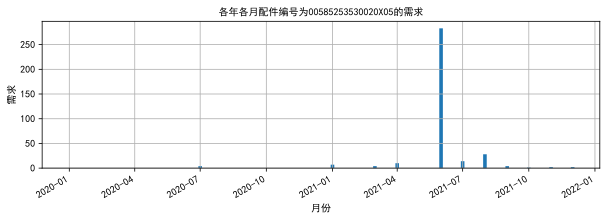

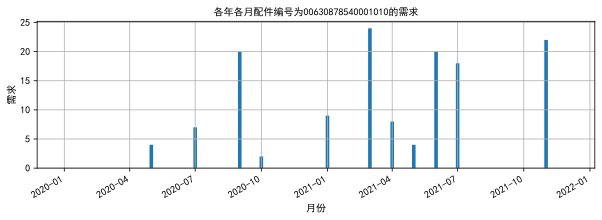

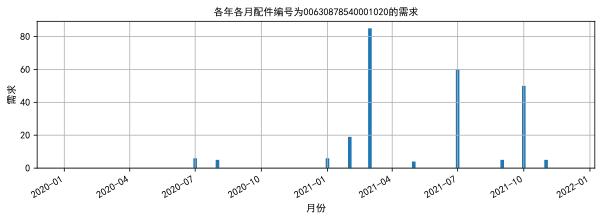

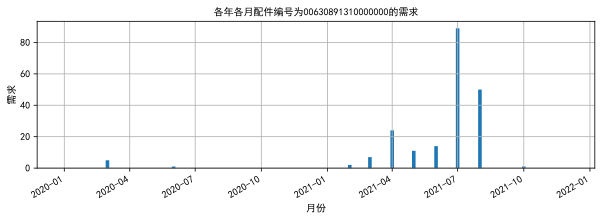

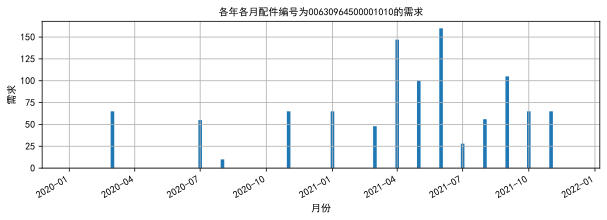

In [67]:
# 新配件可视化
ids = tt.loc[tt['配件生命周期']=='新配件', '物料编号'].values
matrl_full['day'] = 1
matrl_full['date'] = pd.to_datetime(matrl_full[['year', 'month', 'day']])
count = 0
for i in ids:
    plot_monthly(matrl_full[matrl_full['物料编号']==i], 
                ylabel='月订单数量', 
                title='各年各月配件编号为'+i+'的需求')
    count = count + 1
    if count==5:
        break

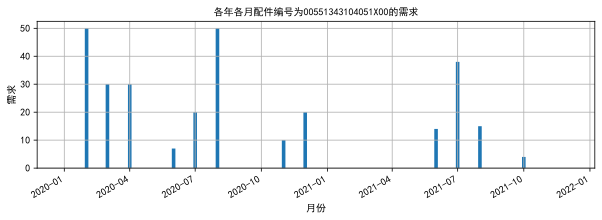

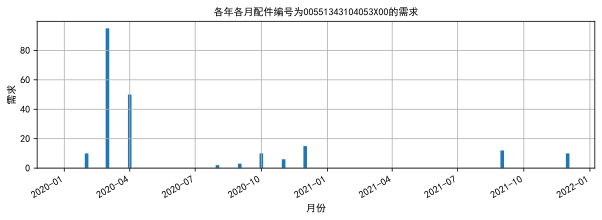

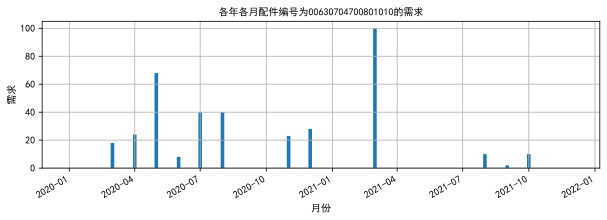

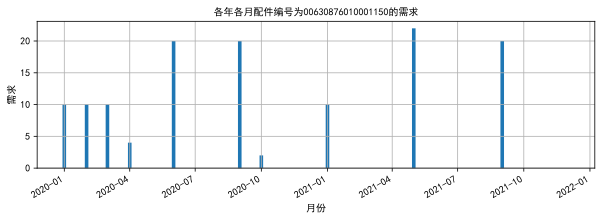

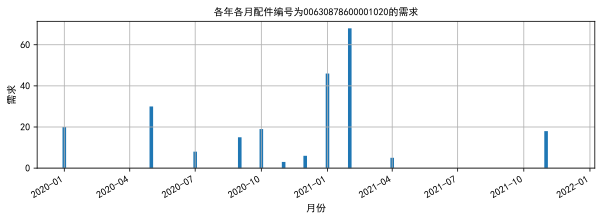

In [68]:
# 老配件可视化
ids = tt.loc[tt['配件生命周期']=='老配件', '物料编号'].values
matrl_full['day'] = 1
matrl_full['date'] = pd.to_datetime(matrl_full[['year', 'month', 'day']])
count = 0
for i in ids:
    plot_monthly(matrl_full[matrl_full['物料编号']==i], 
                ylabel='月订单数量', 
                title='各年各月配件编号为'+i+'的需求')
    count = count + 1
    if count==5:
        break

In [10]:
# ['销售订单编号', '物料编号', '是否三包描述', '基本计量单位', '产品组名称', '产品组代码', 
# '创建日期', 'year', 'month', 'week', 'day', 'weekday', '订单数量', '订单金额', '物料描述', 
# '是否进口件', '物料类别', '周期（天）下计划后的交货周期', '在产情况', '吨位区间', '设备类型']

In [11]:
# 计算每个物料的各种统计量，以及保留相关业务属性（物料类别、计量单位等）
matrl_stats = matrl_full.groupby('物料编号', as_index=False)['月订单数量'].agg({'单配件月需求均值':'mean'})
matrl_stats['单配件月需求最大值'] = matrl_full.groupby('物料编号')['月订单数量'].max().values
matrl_stats['单配件月需求标准差'] = matrl_full.groupby('物料编号')['月订单数量'].std().values
matrl_stats['单配件月需求变异系数'] = matrl_stats['单配件月需求标准差'] / matrl_stats['单配件月需求均值']
matrl_stats['需求平均间隔'] = matrl_full.groupby('物料编号')['月订单数量'].apply(interval_mean).values

# 把月订单数量的0值转换为空值，方便统计非0统计量
matrl_full.loc[matrl_full['月订单数量']==0, '月订单数量'] = np.nan
matrl_stats['单配件月非0需求均值'] = matrl_full.groupby('物料编号')['月订单数量'].mean().values
matrl_stats['单配件月非0需求标准差'] = matrl_full.groupby('物料编号')['月订单数量'].std().values
matrl_stats['单配件月非0需求变异系数'] = matrl_stats['单配件月非0需求标准差'] / matrl_stats['单配件月非0需求均值']

matrl_stats['单月0需求比例'] = 1 - matrl_full.groupby('物料编号')['月订单数量'].count().values / 24
# 统计完以后，把月订单数量的空值重新填0
matrl_full['月订单数量'].fillna(0, inplace=True)

# 加上业务信息
id_class = matrl_full.groupby(['物料编号','物料类别'],as_index=False).count()[['物料编号','物料类别']]
matrl_stats = pd.merge(matrl_stats, id_class, on='物料编号', how='left')
id_measuring = matrl_full.groupby(['物料编号','基本计量单位'],as_index=False).count()[['物料编号','基本计量单位']]
matrl_stats = pd.merge(matrl_stats, id_measuring, on='物料编号', how='left')
id_description = matrl_full.groupby(['物料编号','物料描述'],as_index=False).count()[['物料编号','物料描述']]
matrl_stats = pd.merge(matrl_stats, id_description, on='物料编号', how='left')
id_entrance = matrl_full.groupby(['物料编号','是否进口件'],as_index=False).count()[['物料编号','是否进口件']]
matrl_stats = pd.merge(matrl_stats, id_entrance, on='物料编号', how='left')
id_period = matrl_full.groupby(['物料编号','周期（天）下计划后的交货周期'],as_index=False).count()[['物料编号','周期（天）下计划后的交货周期']]
matrl_stats = pd.merge(matrl_stats, id_period, on='物料编号', how='left')
id_in_production = matrl_full.groupby(['物料编号','在产情况'],as_index=False).count()[['物料编号','在产情况']]
matrl_stats = pd.merge(matrl_stats, id_in_production, on='物料编号', how='left')
id_tonnage = matrl_full.groupby(['物料编号','吨位区间'],as_index=False).count()[['物料编号','吨位区间']]
matrl_stats = pd.merge(matrl_stats, id_tonnage, on='物料编号', how='left')
id_type = matrl_full.groupby(['物料编号','设备类型'],as_index=False).count()[['物料编号','设备类型']]
matrl_stats = pd.merge(matrl_stats, id_type, on='物料编号', how='left')

In [12]:
print(len(matrl_stats))
matrl_stats.head()

20311


,物料编号,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例,物料类别,基本计量单位,物料描述,是否进口件,周期（天）下计划后的交货周期,在产情况,吨位区间,设备类型
0,004700027A265016Z,0.041667,1.0,0.204124,4.898979,12.0,1.0,NaN,NaN,0.958333,未知,PC,未知,未知,未知,未知,未知,未知
1,004700027A265116Z,0.041667,1.0,0.204124,4.898979,12.0,1.0,NaN,NaN,0.958333,电器件类,PC,控制盒主信号线1,否,12,停产,大吨位,汽车吊
2,004700027A265118Z,0.250000,3.0,0.675664,2.702656,4.8,1.5,1.0,0.666667,0.833333,电器件类,PC,主臂角度线,否,12,停产,大吨位,汽车吊
3,004700027A265126Z,0.083333,1.0,0.282330,3.387958,8.0,1.0,0.0,0.000000,0.916667,电器件类,PC,二副臂盒信号线,否,12,停产,大吨位,汽车吊
4,004700027A270001Z,0.083333,1.0,0.282330,3.387958,8.0,1.0,0.0,0.000000,0.916667,电器件类,PC,长角线B段-2,否,12,停产,大吨位,汽车吊


In [14]:
# 不同品类的计量单位
# 需要考虑不同计量单位的影响
matrl_stats.groupby('物料类别')['基本计量单位'].unique()

物料类别
一般结构件类               [PC, EA, KG]
两室                           [PC]
两室配件                 [PC, KG, EA]
传动件传动操纵类             [EA, PC, KG]
减速机                          [PC]
发动机类                  [PC, EA, L]
吊臂(伸缩)                       [PC]
吊臂(基本/顶节)                    [PC]
国标件                 [PC, EA, TAO]
大型结构件类                       [PC]
小型结构件                        [PC]
履带架                          [PC]
底盘车桥类                    [EA, PC]
异型臂                          [PC]
弹簧件类                     [PC, EA]
支腿(固定)                       [PC]
支腿(活动)                       [PC]
未知             [PC, EA, L, M, KG]
标准节                          [PC]
标牌图册类                 [PC, M, MM]
桅杆                           [PC]
橡塑尼龙类                        [PC]
气动元件类                        [PC]
油品类                   [PC, L, KG]
油缸类                          [PC]
泵和阀类                 [PC, EA, KG]
润滑与密封类                [PC, EA, M]
液压件类                     [PC, EA]
滤芯类                      [PC, EA]
电器件类     

In [45]:
matrl_stats.loc[(matrl_stats['单月0需求比例']>0.75) & (matrl_stats['单配件月非0需求均值']>1000)]

,物料编号,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例,物料类别,基本计量单位,物料描述,是否进口件,周期（天）下计划后的交货周期,在产情况,吨位区间,设备类型
18250,1139804723,115.250000,1998.0,430.522761,3.735555,11.5,1383.0,869.741341,0.62888,0.916667,未知,PC,未知,未知,未知,未知,未知,未知
18251,1139804724,115.250000,1998.0,430.522761,3.735555,11.5,1383.0,869.741341,0.62888,0.916667,未知,PC,未知,未知,未知,未知,未知,未知
18252,1139804725,115.250000,1998.0,430.522761,3.735555,11.5,1383.0,869.741341,0.62888,0.916667,未知,PC,未知,未知,未知,未知,未知,未知
19603,1990900229,7616.666667,45700.0,17397.692667,2.284161,4.8,45700.0,0.000000,0.00000,0.833333,标牌图册类,MM,车身反光标识膜,否,6,在产,中小吨位,汽车吊


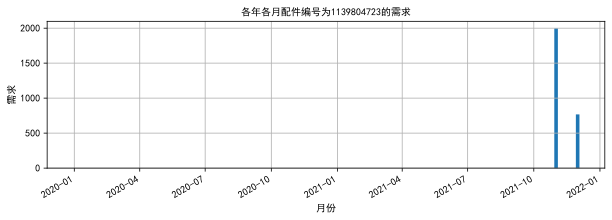

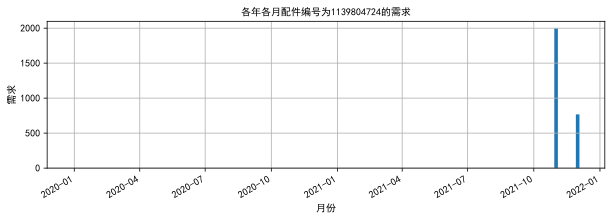

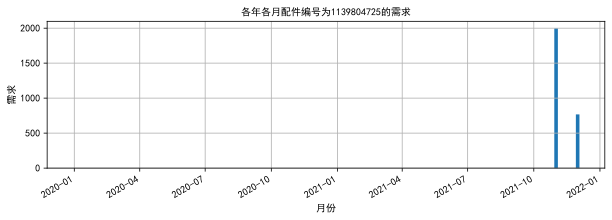

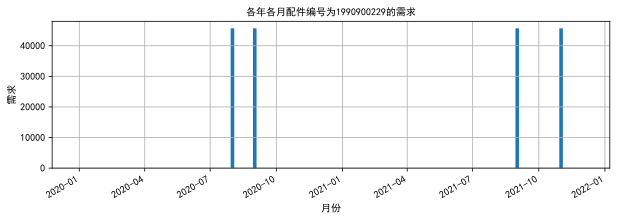

In [50]:
# 可视化
ids = matrl_stats.loc[(matrl_stats['单月0需求比例']>0.75) & (matrl_stats['单配件月非0需求均值']>1000), '物料编号'].values
matrl_full['day'] = 1
matrl_full['date'] = pd.to_datetime(matrl_full[['year', 'month', 'day']])
count = 0
for i in ids:
    plot_monthly(matrl_full[matrl_full['物料编号']==i], 
                ylabel='月订单数量', 
                title='各年各月配件编号为'+i+'的需求')
    count = count + 1
    if count==5:
        break

In [19]:
matrl_stats['物料类别'].value_counts()

一般结构件类       4361
管和接头类        2395
电器件类         1975
未知           1688
橡塑尼龙类         984
传动件传动操纵类      842
国标件           776
泵和阀类          750
小型结构件         705
轴承类           673
发动机类          659
两室配件          654
油缸类           451
钢丝绳类          406
吊臂(伸缩)        349
润滑与密封类        348
辅材杂件类         319
大型结构件类        234
异型臂           200
液压件类          194
滤芯类           176
吊臂(基本/顶节)     166
起重设备类         136
标牌图册类         132
两室            105
标准节            91
转台             86
底盘车桥类          78
弹簧件类           69
减速机            60
气动元件类          60
油品类            49
马达类            48
支腿(活动)         43
桅杆             20
锻件(表面处理)       12
支腿(固定)          7
履带架             5
车架              5
Name: 物料类别, dtype: int64

In [10]:
for i in matrl_stats['物料类别'].unique():
    print(i)
    display(matrl_stats.loc[matrl_stats['物料类别']==i].describe())

未知


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,250.000000,250.000000,1688.000000
mean,0.485012,8.921688,1.905036,4.675363,14.912657,6.577888,19.246897,0.380266,0.949200
std,5.502240,97.370753,20.844395,0.566564,5.700523,64.496241,112.507888,0.357114,0.029730
min,0.002500,0.060000,0.012247,1.688838,1.846154,0.060000,0.000000,0.000000,0.500000
25%,0.041667,1.000000,0.204124,4.898979,12.000000,1.000000,0.000000,0.000000,0.958333
50%,0.041667,1.000000,0.204124,4.898979,12.000000,1.000000,0.707107,0.395980,0.958333
75%,0.083333,2.000000,0.408248,4.898979,23.000000,2.000000,2.543330,0.606092,0.958333
max,115.250000,1998.000000,430.522761,4.898979,24.000000,1383.000000,869.741341,1.467836,0.958333


电器件类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1071.000000,1071.000000,1975.000000
mean,1.309658,7.533215,1.821868,3.574178,8.610349,3.762418,3.541134,0.431557,0.833122
std,7.785206,37.695225,8.453223,1.397944,4.751849,13.006217,15.507096,0.374379,0.213751
min,0.041667,1.000000,0.204124,0.439682,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.041667,1.000000,0.204124,2.443091,4.800000,1.000000,0.000000,0.000000,0.833333
50%,0.125000,1.000000,0.380693,3.587418,8.000000,1.000000,0.707107,0.433761,0.916667
75%,0.375000,3.000000,0.868115,4.898979,12.000000,2.000000,2.121320,0.685244,0.958333
max,194.500000,1102.000000,225.476593,4.898979,24.000000,250.000000,294.248566,1.955282,0.958333


传动件传动操纵类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,482.000000,482.000000,842.000000
mean,2.519497,12.396675,3.050577,3.538040,8.328337,5.850535,5.898827,0.510822,0.821209
std,17.491151,43.574986,12.183016,1.391266,4.633010,18.729909,17.036778,0.419275,0.228171
min,0.041667,1.000000,0.204124,0.368912,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.041667,1.000000,0.204124,2.431675,4.600000,1.000000,0.000000,0.000000,0.791667
50%,0.166667,2.000000,0.488039,3.536553,8.000000,1.500000,1.154701,0.495772,0.916667
75%,0.614583,7.000000,1.664308,4.898979,12.000000,4.000000,4.655191,0.761401,0.958333
max,438.625000,938.000000,288.827436,4.898979,24.000000,438.625000,288.827436,2.555486,0.958333


底盘车桥类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,41.000000,41.000000,78.000000
mean,0.793803,8.756410,2.035197,3.802524,8.869368,4.165937,4.866986,0.529215,0.883013
std,2.152645,23.342279,5.181527,1.149526,4.252786,7.291903,11.895824,0.433588,0.115544
min,0.041667,1.000000,0.204124,0.956375,1.437500,1.000000,0.000000,0.000000,0.333333
25%,0.083333,1.000000,0.282330,2.889260,5.812500,1.000000,0.000000,0.000000,0.843750
50%,0.145833,2.000000,0.464985,3.587418,8.000000,1.643750,0.707107,0.471405,0.916667
75%,0.364583,4.750000,1.062097,4.898979,12.000000,2.875000,3.000000,0.727942,0.958333
max,12.000000,153.000000,32.009255,4.898979,24.000000,45.000000,62.349820,1.385552,0.958333


吊臂(基本/顶节)


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,81.000000,81.000000,166.000000
mean,0.119729,1.373494,0.346081,3.861646,9.855594,1.185962,0.263371,0.161609,0.904618
std,0.142221,0.956139,0.248580,1.160097,4.117487,0.609141,0.502129,0.263861,0.087888
min,0.041667,1.000000,0.204124,1.052946,1.533333,1.000000,0.000000,0.000000,0.375000
25%,0.041667,1.000000,0.204124,2.702656,7.666667,1.000000,0.000000,0.000000,0.875000
50%,0.083333,1.000000,0.282330,4.898979,12.000000,1.000000,0.000000,0.000000,0.958333
75%,0.125000,1.000000,0.369978,4.898979,12.000000,1.000000,0.447214,0.370328,0.958333
max,1.125000,6.000000,1.648451,4.898979,24.000000,5.000000,2.500000,1.111111,0.958333


橡塑尼龙类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,633.000000,633.000000,984.000000
mean,2.699314,15.173780,3.584434,3.435494,7.902079,6.086515,6.260129,0.589262,0.813813
std,22.729143,76.421898,17.669100,1.298473,4.648295,24.137294,23.489508,0.502792,0.215033
min,0.041667,1.000000,0.204124,0.473257,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.083333,2.000000,0.408248,2.440237,4.000000,1.250000,0.000000,0.000000,0.791667
50%,0.208333,3.000000,0.737210,3.387958,8.000000,2.000000,1.414214,0.554861,0.916667
75%,0.791667,8.000000,1.941557,4.898979,12.000000,4.013158,4.423961,0.860990,0.958333
max,461.166667,1635.000000,395.628996,4.898979,24.000000,461.166667,395.628996,2.765446,0.958333


一般结构件类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000,4361.000000,2110.000000,2110.000000,4361.000000
mean,0.731001,6.452658,1.542447,3.856286,9.416804,3.517212,3.355386,0.379335,0.880551
std,3.797589,27.701080,6.586332,1.223518,4.221192,9.877100,13.479005,0.398677,0.152887
min,0.041667,1.000000,0.204124,0.369857,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.041667,1.000000,0.204124,2.889260,6.000000,1.000000,0.000000,0.000000,0.875000
50%,0.083333,2.000000,0.408248,4.898979,12.000000,1.400000,0.577350,0.384900,0.958333
75%,0.250000,3.000000,0.816497,4.898979,12.000000,2.000000,1.687249,0.600000,0.958333
max,105.375000,713.000000,172.575876,4.898979,24.000000,216.000000,220.949240,2.400992,0.958333


大型结构件类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,130.000000,130.000000,234.000000
mean,0.190527,1.628205,0.413480,3.587185,8.531423,1.225930,0.438510,0.270853,0.867343
std,0.298737,1.109177,0.296445,1.317652,3.919349,0.412565,0.466894,0.255262,0.145292
min,0.041667,1.000000,0.204124,0.659483,1.150000,1.000000,0.000000,0.000000,0.125000
25%,0.041667,1.000000,0.204124,2.572267,5.750000,1.000000,0.000000,0.000000,0.833333
50%,0.083333,1.000000,0.282330,3.387958,8.000000,1.000000,0.475430,0.369801,0.916667
75%,0.208333,2.000000,0.481543,4.898979,12.000000,1.333333,0.705132,0.471405,0.958333
max,2.791667,7.000000,1.841058,4.898979,24.000000,3.600000,1.732051,0.979796,0.958333


轴承类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,673.000000,673.000000,673.000000,673.000000,673.000000,673.000000,378.000000,378.000000,673.000000
mean,1.247709,9.846954,2.411685,3.692322,8.800057,5.219269,4.967725,0.497713,0.855931
std,4.829106,32.066088,8.192943,1.255637,4.386480,15.553849,16.130555,0.424004,0.181529
min,0.041667,1.000000,0.204124,0.643195,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.083333,2.000000,0.408248,2.702656,6.000000,1.250000,0.000000,0.000000,0.875000
50%,0.166667,2.000000,0.612372,3.587418,8.000000,2.000000,1.154701,0.471405,0.916667
75%,0.500000,6.000000,1.403928,4.898979,12.000000,4.000000,3.840326,0.723999,0.958333
max,76.208333,584.000000,155.486328,4.898979,24.000000,252.000000,199.025438,2.024405,0.958333


管和接头类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,1018.000000,1018.000000,2395.000000
mean,0.459388,4.937633,1.129369,4.031943,10.295009,2.470955,2.942680,0.487491,0.893215
std,1.919082,24.565843,5.112252,1.138001,4.802919,4.460922,10.989024,0.427655,0.136836
min,0.041667,1.000000,0.204124,0.615004,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.041667,1.000000,0.204124,3.387958,8.000000,1.000000,0.000000,0.000000,0.875000
50%,0.083333,2.000000,0.408248,4.898979,12.000000,1.200000,0.707107,0.471405,0.958333
75%,0.208333,3.000000,0.796014,4.898979,12.000000,2.088462,2.377509,0.707386,0.958333
max,41.833333,821.000000,167.488524,4.898979,24.000000,100.000000,217.539538,3.100708,0.958333


钢丝绳类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,307.000000,307.000000,406.000000
mean,1.500718,6.177340,1.606456,2.737919,6.347635,2.988696,1.892299,0.389182,0.717878
std,4.063463,12.397056,3.074410,1.486133,4.694963,4.555141,3.491649,0.284746,0.279943
min,0.041667,1.000000,0.204124,0.487890,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.083333,1.000000,0.337832,1.465909,2.211364,1.000000,0.000000,0.000000,0.583333
50%,0.250000,2.000000,0.588230,2.443091,4.800000,1.633929,0.707107,0.430730,0.833333
75%,0.875000,4.000000,1.358673,3.587418,11.500000,2.666667,1.601600,0.567414,0.916667
max,40.875000,93.000000,24.288983,4.898979,24.000000,42.652174,26.367715,1.450706,0.958333


油缸类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,312.000000,312.000000,451.000000
mean,0.614098,2.842572,0.743429,3.076884,7.320612,1.752791,0.798823,0.312495,0.786585
std,2.013794,4.515608,1.110690,1.440532,4.529260,2.187128,1.329198,0.287033,0.238196
min,0.041667,1.000000,0.204124,0.414529,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.041667,1.000000,0.204124,1.911066,3.428571,1.000000,0.000000,0.000000,0.750000
50%,0.166667,1.000000,0.408248,2.948839,7.666667,1.000000,0.500000,0.369592,0.875000
75%,0.375000,3.000000,0.772601,4.898979,12.000000,1.750000,1.015719,0.524897,0.958333
max,30.250000,52.000000,12.539503,4.898979,24.000000,30.250000,12.539503,1.102466,0.958333


辅材杂件类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,184.000000,184.000000,319.000000
mean,3.677957,24.602476,5.759289,3.637917,8.538552,9.381838,10.381284,0.522046,0.853579
std,25.097404,143.133670,32.234112,1.263728,4.332663,34.947429,45.259845,0.380480,0.171855
min,0.005833,0.140000,0.028577,0.718710,1.045455,0.140000,0.000000,0.000000,0.041667
25%,0.083333,1.000000,0.282330,2.653500,4.800000,1.000000,0.500000,0.326542,0.833333
50%,0.166667,2.000000,0.508977,3.587418,8.000000,2.000000,1.000000,0.495967,0.916667
75%,0.541667,6.000000,1.316011,4.898979,12.000000,3.500000,3.364583,0.785462,0.958333
max,351.541667,2000.000000,453.014011,4.898979,23.000000,383.500000,503.970266,1.667901,0.958333


转台


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,24.000000,24.000000,86.000000
mean,0.078488,1.197674,0.281384,4.320596,10.804485,1.154762,0.141436,0.086393,0.932171
std,0.066550,0.455548,0.127213,0.993089,3.333066,0.370295,0.255044,0.156937,0.055736
min,0.041667,1.000000,0.204124,1.591905,3.000000,1.000000,0.000000,0.000000,0.708333
25%,0.041667,1.000000,0.204124,3.387958,11.500000,1.000000,0.000000,0.000000,0.916667
50%,0.041667,1.000000,0.204124,4.898979,12.000000,1.000000,0.000000,0.000000,0.958333
75%,0.083333,1.000000,0.337832,4.898979,12.000000,1.000000,0.094491,0.061859,0.958333
max,0.333333,3.000000,0.806450,4.898979,24.000000,2.500000,0.707107,0.433013,0.958333


发动机类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,379.000000,379.000000,659.000000
mean,1.892453,13.805766,3.455317,3.466624,8.308949,5.813326,7.376091,0.425762,0.821573
std,12.211501,90.278488,23.567981,1.418853,4.786060,36.226106,39.430988,0.393914,0.217779
min,0.041667,1.000000,0.204124,0.491715,1.000000,0.680000,0.000000,0.000000,0.000000
25%,0.041667,1.000000,0.204124,2.284161,4.000000,1.000000,0.000000,0.000000,0.791667
50%,0.125000,1.000000,0.380693,3.387958,8.000000,1.000000,0.577350,0.433013,0.916667
75%,0.416667,4.000000,0.943545,4.898979,12.000000,2.000000,2.192303,0.666667,0.958333
max,252.583333,1511.000000,456.588190,4.898979,24.000000,757.750000,497.501400,1.751207,0.958333


泵和阀类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,524.000000,524.000000,750.000000
mean,1.608667,6.806667,1.667756,2.931218,6.803825,2.835542,2.298360,0.466697,0.731056
std,5.981400,20.656546,4.537161,1.516044,4.883699,5.988218,5.459763,0.356364,0.281973
min,0.041667,1.000000,0.204124,0.438199,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.083333,1.000000,0.282330,1.573222,2.400000,1.000000,0.216506,0.117851,0.625000
50%,0.208333,2.000000,0.481543,2.702656,6.000000,1.333333,0.768832,0.471405,0.875000
75%,0.822917,5.000000,1.232853,4.898979,12.000000,2.219298,2.128389,0.666667,0.958333
max,70.166667,312.000000,67.059135,4.898979,24.000000,70.166667,67.059135,1.998794,0.958333


吊臂(伸缩)


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,203.000000,203.000000,349.000000
mean,0.246896,1.593123,0.420936,3.477924,8.569449,1.203806,0.380608,0.207970,0.845392
std,0.518438,1.464350,0.376453,1.390230,4.444277,0.478041,0.593524,0.264221,0.192317
min,0.041667,1.000000,0.204124,0.525792,1.045455,1.000000,0.000000,0.000000,0.041667
25%,0.041667,1.000000,0.204124,2.366582,4.800000,1.000000,0.000000,0.000000,0.833333
50%,0.083333,1.000000,0.282330,3.387958,8.000000,1.000000,0.000000,0.000000,0.916667
75%,0.208333,2.000000,0.448427,4.898979,12.000000,1.200000,0.577350,0.400000,0.958333
max,4.708333,12.000000,2.929114,4.898979,24.000000,4.913043,3.044120,1.111111,0.958333


标牌图册类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,43.000000,43.000000,132.000000
mean,137.467677,808.305303,287.388896,4.145778,10.247910,620.794779,538.429043,0.575834,0.894255
std,1120.591458,6554.124020,2320.671461,1.176325,4.529529,5033.245245,3501.060296,0.378783,0.139994
min,0.041667,1.000000,0.204124,0.986151,1.200000,1.000000,0.000000,0.000000,0.166667
25%,0.041667,1.000000,0.204124,3.375026,7.916667,1.000000,0.577350,0.364513,0.906250
50%,0.083333,2.000000,0.408248,4.898979,12.000000,1.708333,1.258306,0.494872,0.958333
75%,0.218750,3.000000,0.728446,4.898979,12.000000,2.212500,3.207622,0.794234,0.958333
max,10439.333333,60208.000000,20340.131919,4.898979,24.000000,45700.000000,22962.373977,1.587451,0.958333


液压件类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,128.000000,128.000000,194.000000
mean,1.338703,5.701031,1.447950,3.126247,7.201313,2.821666,1.972021,0.418649,0.769115
std,5.050192,13.083760,3.233479,1.486990,4.497473,5.219158,3.946549,0.345103,0.265363
min,0.041667,1.000000,0.204124,0.507886,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.041667,1.000000,0.204124,1.885827,3.071429,1.000000,0.000000,0.000000,0.708333
50%,0.166667,2.000000,0.464985,3.069620,6.000000,1.285714,0.707107,0.433013,0.875000
75%,0.572917,4.750000,1.247634,4.898979,12.000000,2.250000,1.919727,0.598045,0.958333
max,60.666667,130.000000,30.811724,4.898979,24.000000,60.666667,30.811724,1.295005,0.958333


弹簧件类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,49.000000,49.000000,69.000000
mean,9.128623,44.695652,11.416314,3.293809,7.062680,17.369500,17.707489,0.759927,0.756039
std,22.677881,80.100544,21.085005,1.357901,4.502384,27.114023,25.440301,0.411847,0.282622
min,0.041667,1.000000,0.204124,0.709678,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.166667,2.000000,0.588230,2.634249,2.875000,2.000000,1.414214,0.471405,0.666667
50%,0.416667,10.000000,2.041241,3.387958,6.000000,6.500000,5.228129,0.787420,0.875000
75%,4.166667,50.000000,11.875868,4.898979,12.000000,17.000000,20.688161,1.060918,0.958333
max,139.750000,432.000000,110.041988,4.898979,24.000000,139.750000,110.041988,1.533762,0.958333


小型结构件


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,231.000000,231.000000,705.000000
mean,0.241017,2.913475,0.683015,4.268169,10.947596,2.269045,1.453240,0.277802,0.921868
std,0.858850,6.807387,1.749149,1.002140,3.816744,3.697072,4.362909,0.348111,0.093974
min,0.041667,1.000000,0.204124,0.645582,1.000000,1.000000,0.000000,0.000000,0.041667
25%,0.041667,1.000000,0.204124,3.387958,8.000000,1.000000,0.000000,0.000000,0.916667
50%,0.083333,1.000000,0.282330,4.898979,12.000000,1.000000,0.000000,0.000000,0.958333
75%,0.166667,2.000000,0.564660,4.898979,12.000000,2.000000,0.978714,0.471405,0.958333
max,11.625000,89.000000,25.158303,4.898979,24.000000,40.000000,33.368791,1.389600,0.958333


国标件


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,776.000000,776.000000,776.000000,776.000000,776.000000,776.000000,599.000000,599.000000,776.000000
mean,18.522444,170.378866,38.958702,2.980333,6.309548,37.804988,56.969433,0.810703,0.731637
std,71.745148,874.235366,183.601786,1.305447,5.051542,96.814283,234.301324,0.436267,0.242953
min,0.041667,1.000000,0.204124,0.500152,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.458333,8.000000,1.665942,1.868891,2.400000,5.000000,5.131601,0.559018,0.625000
50%,2.666667,26.000000,6.651947,2.702888,4.600000,12.690476,13.114877,0.803137,0.791667
75%,9.125000,85.500000,20.694975,4.157204,11.500000,37.044118,34.306206,1.014110,0.916667
max,850.875000,10835.000000,2226.953745,4.898979,24.000000,1132.500000,2659.854432,3.233806,0.958333


起重设备类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,68.000000,68.000000,136.000000
mean,0.294118,2.227941,0.561029,3.749629,8.971374,1.529300,0.792147,0.264708,0.874694
std,1.034186,3.856629,0.938321,1.291811,3.855701,1.558744,1.755297,0.325035,0.153784
min,0.041667,1.000000,0.204124,0.596971,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.041667,1.000000,0.204124,2.702656,6.000000,1.000000,0.000000,0.000000,0.875000
50%,0.083333,1.000000,0.282330,4.243199,11.750000,1.000000,0.000000,0.000000,0.937500
75%,0.166667,2.000000,0.448427,4.898979,12.000000,1.500000,0.707107,0.471405,0.958333
max,11.500000,30.000000,6.865161,4.898979,23.000000,11.500000,10.796604,1.516868,0.958333


润滑与密封类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,215.000000,215.000000,348.000000
mean,1.428954,9.162644,2.255148,3.568166,8.414634,4.144859,4.179975,0.539434,0.846264
std,5.983646,24.224262,6.212494,1.249954,4.695927,7.700021,8.554769,0.417487,0.179145
min,0.041667,1.000000,0.204124,0.516518,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.083333,1.000000,0.282330,2.611879,4.800000,1.000000,0.188982,0.066617,0.833333
50%,0.166667,2.000000,0.508977,3.498342,8.000000,2.000000,1.414214,0.471405,0.916667
75%,0.541667,7.000000,1.725764,4.898979,12.000000,4.031250,4.376038,0.810423,0.958333
max,67.958333,280.000000,75.982538,4.898979,24.000000,76.176471,80.628186,1.599325,0.958333


车架


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,5.000000,5.0,5.000000e+00,5.000000e+00,5.0,5.0,0.0,0.0,5.000000
mean,0.041667,1.0,2.041241e-01,4.898979e+00,12.0,1.0,NaN,NaN,0.958333
std,0.000000,0.0,1.387779e-17,4.440892e-16,0.0,0.0,NaN,NaN,0.000000
min,0.041667,1.0,2.041241e-01,4.898979e+00,12.0,1.0,NaN,NaN,0.958333
25%,0.041667,1.0,2.041241e-01,4.898979e+00,12.0,1.0,NaN,NaN,0.958333
50%,0.041667,1.0,2.041241e-01,4.898979e+00,12.0,1.0,NaN,NaN,0.958333
75%,0.041667,1.0,2.041241e-01,4.898979e+00,12.0,1.0,NaN,NaN,0.958333
max,0.041667,1.0,2.041241e-01,4.898979e+00,12.0,1.0,NaN,NaN,0.958333


锻件(表面处理)


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,12.000000,12.000000,12.000000,12.000000,12.00000,12.000000,7.000000,7.000000,12.000000
mean,0.447917,5.416667,1.382230,3.786506,8.93750,3.284722,3.633619,0.669276,0.895833
std,0.595947,6.529073,1.749244,0.996849,3.11544,3.309090,3.707972,0.331933,0.060250
min,0.041667,1.000000,0.204124,2.585728,5.75000,1.000000,0.000000,0.000000,0.833333
25%,0.041667,1.000000,0.204124,2.986958,6.00000,1.000000,1.392915,0.566034,0.833333
50%,0.250000,4.000000,0.893072,3.204810,8.75000,2.458333,3.774917,0.888216,0.895833
75%,0.708333,8.000000,2.115762,4.898979,12.00000,4.250000,3.774917,0.888216,0.958333
max,2.125000,24.000000,6.347286,4.898979,12.00000,12.750000,11.324752,0.888216,0.958333


支腿(活动)


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,20.000000,20.000000,43.000000
mean,0.131783,1.558140,0.383605,3.867415,9.114064,1.320856,0.456288,0.285578,0.901163
std,0.119913,0.733625,0.198464,1.224063,3.396902,0.434138,0.456888,0.231862,0.086747
min,0.041667,1.000000,0.204124,1.438205,2.666667,1.000000,0.000000,0.000000,0.625000
25%,0.041667,1.000000,0.204124,2.889260,6.000000,1.000000,0.000000,0.000000,0.875000
50%,0.083333,1.000000,0.408248,4.898979,12.000000,1.000000,0.521722,0.347799,0.958333
75%,0.166667,2.000000,0.481543,4.898979,12.000000,1.500000,0.577350,0.433013,0.958333
max,0.541667,4.000000,0.907896,4.898979,12.000000,2.333333,1.527525,0.654654,0.958333


两室配件


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,654.000000,654.000000,654.000000,654.000000,654.000000,654.000000,465.000000,465.000000,654.000000
mean,1.075242,6.587156,1.624002,3.079704,6.807550,3.201444,2.519075,0.502191,0.764845
std,2.382690,13.983940,3.263893,1.421283,4.174424,5.380113,5.721100,0.378745,0.253485
min,0.041667,1.000000,0.204124,0.351037,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.083333,1.000000,0.282330,1.820534,2.875000,1.000000,0.377964,0.202031,0.666667
50%,0.208333,2.000000,0.612372,3.023303,6.000000,1.571429,1.000000,0.499433,0.875000
75%,0.906250,6.000000,1.731528,4.898979,12.000000,3.163462,2.828427,0.740540,0.958333
max,18.458333,200.000000,45.176626,4.898979,23.000000,73.833333,67.516488,2.442639,0.958333


滤芯类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,149.000000,149.000000,176.000000
mean,11.693182,32.386364,8.940664,2.493176,5.041094,14.957676,10.913007,0.655817,0.633049
std,39.264153,75.441471,21.109875,1.397547,3.914079,40.327864,22.109008,0.347236,0.315748
min,0.041667,1.000000,0.204124,0.414614,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.125000,2.000000,0.448427,1.255781,1.533333,1.500000,0.836660,0.471405,0.364583
50%,1.041667,7.500000,2.062989,2.284161,3.428571,3.250000,3.165869,0.672438,0.750000
75%,3.239583,24.000000,5.301207,3.467046,8.000000,8.083333,8.710147,0.833196,0.916667
max,355.708333,586.000000,163.398281,4.898979,12.000000,355.708333,163.398281,1.828505,0.958333


支腿(固定)


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,3.000000,3.000000,7.000000
mean,0.089286,1.428571,0.317475,4.173406,9.828571,1.178571,0.638071,0.447603,0.928571
std,0.065566,0.534522,0.142807,0.982054,2.910735,0.237797,0.119573,0.041225,0.046362
min,0.041667,1.000000,0.204124,2.443091,4.800000,1.000000,0.500000,0.400000,0.833333
25%,0.041667,1.000000,0.204124,3.587418,8.000000,1.000000,0.603553,0.435702,0.916667
50%,0.041667,1.000000,0.204124,4.898979,12.000000,1.000000,0.707107,0.471405,0.958333
75%,0.125000,2.000000,0.448427,4.898979,12.000000,1.375000,0.707107,0.471405,0.958333
max,0.208333,2.000000,0.508977,4.898979,12.000000,1.500000,0.707107,0.471405,0.958333


异型臂


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,64.000000,64.000000,200.000000
mean,0.090000,1.400000,0.327737,4.285778,10.577605,1.333728,0.173404,0.110383,0.932500
std,0.106778,1.396334,0.335300,0.954619,3.017775,1.358147,0.317177,0.198065,0.052099
min,0.041667,1.000000,0.204124,1.535411,2.555556,1.000000,0.000000,0.000000,0.625000
25%,0.041667,1.000000,0.204124,3.387958,8.000000,1.000000,0.000000,0.000000,0.916667
50%,0.041667,1.000000,0.204124,4.898979,12.000000,1.000000,0.000000,0.000000,0.958333
75%,0.083333,1.000000,0.282330,4.898979,12.000000,1.000000,0.359656,0.170637,0.958333
max,0.916667,12.000000,3.105628,4.898979,23.000000,12.000000,1.414214,0.707107,0.958333


标准节


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,30.000000,30.000000,91.000000
mean,0.103938,1.505495,0.354810,4.214607,10.136918,1.372135,0.332560,0.193326,0.926740
std,0.099259,0.750905,0.204581,1.033798,2.886020,0.559603,0.406585,0.231662,0.057715
min,0.041667,1.000000,0.204124,1.693979,3.000000,1.000000,0.000000,0.000000,0.708333
25%,0.041667,1.000000,0.204124,3.387958,8.000000,1.000000,0.000000,0.000000,0.916667
50%,0.083333,1.000000,0.282330,4.898979,12.000000,1.000000,0.000000,0.000000,0.958333
75%,0.125000,2.000000,0.408248,4.898979,12.000000,2.000000,0.577350,0.370796,0.958333
max,0.500000,4.000000,1.063219,4.898979,12.000000,3.000000,1.414214,0.707107,0.958333


桅杆


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,4.000000,4.000000,20.000000
mean,0.068750,1.200000,0.267766,4.478509,11.045000,1.160000,0.111803,0.093169,0.939583
std,0.052834,0.410391,0.101216,0.904804,2.346436,0.364764,0.223607,0.186339,0.045793
min,0.041667,1.000000,0.204124,2.126438,4.600000,1.000000,0.000000,0.000000,0.791667
25%,0.041667,1.000000,0.204124,4.898979,12.000000,1.000000,0.000000,0.000000,0.958333
50%,0.041667,1.000000,0.204124,4.898979,12.000000,1.000000,0.000000,0.000000,0.958333
75%,0.083333,1.000000,0.306921,4.898979,12.000000,1.000000,0.111803,0.093169,0.958333
max,0.250000,2.000000,0.531610,4.898979,12.000000,2.000000,0.447214,0.372678,0.958333


履带架


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,5.000000,5.00000,5.000000,5.000000,5.000000,5.00000,1.0,1.0,5.000000
mean,0.141667,3.20000,0.668838,4.596775,11.200000,3.20000,0.0,0.0,0.950000
std,0.201125,4.91935,0.995990,0.675749,1.788854,4.91935,NaN,NaN,0.018634
min,0.041667,1.00000,0.204124,3.387958,8.000000,1.00000,0.0,0.0,0.916667
25%,0.041667,1.00000,0.204124,4.898979,12.000000,1.00000,0.0,0.0,0.958333
50%,0.041667,1.00000,0.204124,4.898979,12.000000,1.00000,0.0,0.0,0.958333
75%,0.083333,1.00000,0.282330,4.898979,12.000000,1.00000,0.0,0.0,0.958333
max,0.500000,12.00000,2.449490,4.898979,12.000000,12.00000,0.0,0.0,0.958333


气动元件类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,43.000000,43.000000,60.000000
mean,0.819444,5.500000,1.384374,3.106900,7.062371,2.607053,1.963164,0.488746,0.777778
std,1.309049,8.112556,1.853083,1.348103,4.514147,2.442176,2.893935,0.395733,0.239008
min,0.041667,1.000000,0.204124,0.744510,1.095238,1.000000,0.000000,0.000000,0.125000
25%,0.041667,1.000000,0.204124,2.136422,3.290179,1.000000,0.204124,0.078567,0.729167
50%,0.250000,2.000000,0.594377,2.856382,6.833333,1.775000,1.154701,0.471405,0.875000
75%,0.833333,8.000000,1.790163,4.898979,12.000000,3.375000,2.897098,0.745149,0.958333
max,5.458333,54.000000,11.244322,4.898979,23.000000,12.500000,17.484687,1.457057,0.958333


油品类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,45.000000,45.000000,49.000000
mean,282.931199,1729.083673,442.090264,2.156140,3.833010,454.043682,537.802123,0.913399,0.505952
std,629.118568,4398.517215,1096.547207,1.188013,4.247938,877.050210,1278.371742,0.373619,0.322300
min,0.083333,2.000000,0.408248,0.726415,1.000000,1.500000,0.000000,0.000000,0.000000
25%,5.333333,64.000000,16.333259,1.204980,1.277778,30.444444,31.382865,0.727999,0.208333
50%,78.541667,371.000000,95.250233,1.744928,2.000000,130.526316,116.116497,0.853205,0.500000
75%,272.875000,1242.000000,312.352826,2.658242,4.800000,467.952381,477.135695,1.083576,0.833333
max,3459.500000,27691.000000,6608.167219,4.898979,23.000000,4612.666667,7678.257933,2.187831,0.958333


马达类


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,35.000000,35.000000,48.000000
mean,1.756944,9.687500,2.089447,2.972008,6.569432,2.716221,2.721847,0.410330,0.756076
std,6.866741,32.875106,6.728136,1.390900,4.004894,6.704212,7.872474,0.420814,0.280891
min,0.041667,1.000000,0.204124,0.620880,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.072917,1.000000,0.262778,1.861810,3.214286,1.000000,0.000000,0.000000,0.708333
50%,0.166667,1.000000,0.394471,2.638077,5.400000,1.000000,0.534522,0.379517,0.854167
75%,0.343750,3.000000,0.712525,4.898979,12.000000,1.541667,0.943068,0.625625,0.958333
max,46.125000,212.000000,43.460439,4.898979,12.000000,46.125000,43.460439,1.560785,0.958333


减速机


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,39.000000,39.000000,60.000000
mean,0.485417,2.533333,0.641346,3.123039,7.210488,1.539409,0.776775,0.369045,0.792361
std,1.095403,2.782918,0.644114,1.494947,4.621254,0.984088,0.869734,0.293715,0.226209
min,0.041667,1.000000,0.204124,0.382533,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.041667,1.000000,0.204124,1.921377,3.285714,1.000000,0.000000,0.000000,0.708333
50%,0.166667,2.000000,0.431639,2.795958,6.000000,1.200000,0.534522,0.382533,0.875000
75%,0.416667,2.000000,0.718226,4.898979,12.000000,1.717532,1.056349,0.526745,0.958333
max,6.958333,16.000000,3.629339,4.898979,24.000000,6.958333,3.685756,1.082532,0.958333


两室


,单配件月需求均值,单配件月需求最大值,单配件月需求标准差,单配件月需求变异系数,需求平均间隔,单配件月非0需求均值,单配件月非0需求标准差,单配件月非0需求变异系数,单月0需求比例
count,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,71.000000,71.000000,105.000000
mean,0.488095,2.209524,0.608094,2.888329,6.620046,1.392134,0.567193,0.294164,0.744048
std,0.892093,2.195692,0.589143,1.583423,4.348800,0.854756,0.681927,0.252823,0.259272
min,0.041667,1.000000,0.204124,0.546288,1.045455,1.000000,0.000000,0.000000,0.041667
25%,0.041667,1.000000,0.204124,1.438205,2.400000,1.000000,0.000000,0.000000,0.625000
50%,0.166667,1.000000,0.380693,2.702656,6.000000,1.000000,0.440959,0.356348,0.875000
75%,0.500000,2.000000,0.779028,4.898979,12.000000,1.411765,0.781077,0.489039,0.958333
max,7.000000,16.000000,4.107258,4.898979,12.000000,7.636364,3.658590,0.736084,0.958333


In [14]:
def rename(newname):
    def decorator(f):
        f.__name__ = newname
        return f
    return decorator

def q_at(y):
    @rename(f'q{y:0.2f}')
    def q(x):
        return x.quantile(y)
    return q

f = {'需求平均间隔': 
     [q_at(0.1), q_at(0.2), q_at(0.25), q_at(0.3), q_at(0.4), 'median', q_at(0.6), q_at(0.7), q_at(0.75), q_at(0.8), q_at(0.9), q_at(1)]}
matrl_stats.groupby('物料类别').agg(f)

需求平均间隔                                                         \
               q0.10      q0.20      q0.25      q0.30      q0.40     median   
物料类别                                                                          
一般结构件类      3.428571   5.750000   6.000000   8.000000   8.000000  12.000000   
两室          1.352941   2.072727   2.400000   2.666667   4.000000   6.000000   
两室配件        1.437500   2.360000   2.875000   3.428571   4.800000   6.000000   
传动件传动操纵类    1.846154   3.833333   4.600000   5.750000   7.666667   8.000000   
减速机         1.991667   3.000000   3.285714   3.828571   4.800000   6.000000   
发动机类        1.916667   3.428571   4.000000   4.800000   7.666667   8.000000   
吊臂(伸缩)      2.380000   4.600000   4.800000   6.000000   8.000000   8.000000   
吊臂(基本/顶节)   4.300000   6.000000   7.666667   8.000000   8.000000  12.000000   
国标件         1.533333   2.181818   2.400000   2.875000   3.428571   4.600000   
大型结构件类      2.912500   4.800000   5.750000   6.000000   8.000000   8.000000   
小型结构件       6.000000   8.000000   8.000000  11.500000  12.000000  12.000000   
履带架         9.600000  11.200000  12.000000  12.000000  12.000000  12.000000   
底盘车桥类       4.000000   4.800000   5.812500   6.000000   7.933333   8.000000   
异型臂         6.000000   8.000000   8.000000  11.500000  12.000000  12.000000   
弹簧件类        1.277778   2.181818   2.875000   4.240000   6.000000   6.000000   
支腿(固定)      6.720000   8.000000   8.000000   8.000000   9.600000  12.000000   
支腿(活动)      4.000000   6.000000   6.000000   7.000000   8.000000  12.000000   
未知          8.000000  12.000000  12.000000  12.000000  12.000000  12.000000   
标准节         6.000000   7.666667   8.000000   8.000000  12.000000  12.000000   
标牌图册类       4.000000   4.800000   7.916667   8.000000  12.000000  12.000000   
桅杆          7.680000  11.900000  12.000000  12.000000  12.000000  12.000000   
橡塑尼龙类       1.846154   3.171429   4.000000   4.800000   6.000000   8.000000   
气动元件类       1.642857   2.338182   3.290179   4.000000   4.800000   6.833333   
油品类         1.085281   1.150000   1.277778   1.375000   1.642857   2.000000   
油缸类         1.600000   2.666667   3.428571   4.000000   4.800000   7.666667   
泵和阀类        1.277778   1.916667   2.400000   2.962500   4.000000   6.000000   
润滑与密封类      2.666667   4.000000   4.800000   5.750000   6.000000   8.000000   
液压件类        1.437500   2.400000   3.071429   3.833333   5.750000   6.000000   
滤芯类         1.045455   1.411765   1.533333   1.916667   2.555556   3.428571   
电器件类        2.000000   4.000000   4.800000   6.000000   8.000000   8.000000   
管和接头类       3.900000   6.000000   8.000000   8.000000  11.500000  12.000000   
起重设备类       2.833333   6.000000   6.000000   7.666667   8.000000  11.750000   
车架         12.000000  12.000000  12.000000  12.000000  12.000000  12.000000   
转台          6.000000   8.000000  11.500000  12.000000  12.000000  12.000000   
轴承类         2.666667   4.800000   6.000000   6.000000   8.000000   8.000000   
辅材杂件类       2.666667   4.000000   4.800000   6.000000   8.000000   8.000000   
钢丝绳类        1.210526   1.916667   2.211364   2.555556   3.833333   4.800000   
锻件(表面处理)    6.000000   6.000000   6.000000   6.000000   6.000000   8.750000   
马达类         1.254444   3.000000   3.214286   4.060000   4.800000   5.400000   

                                                          
               q0.60      q0.70 q0.75  q0.80 q0.90 q1.00  
物料类别                                                      
一般结构件类     12.000000  12.000000  12.0  12.00  12.0  24.0  
两室          8.000000  12.000000  12.0  12.00  12.0  12.0  
两室配件        8.000000  11.500000  12.0  12.00  12.0  23.0  
传动件传动操纵类   12.000000  12.000000  12.0  12.00  12.0  24.0  
减速机         8.000000  12.000000  12.0  12.00  12.0  24.0  
发动机类       12.000000  12.000000  12.0  12.00  12.0  24.0  
吊臂(伸缩)     12.000000  12.000000  12.0  12.00  12.0  24.0  
吊臂(基本/顶节)  12.000000  12.000000  12.0  12.00  12.0  24.0  
国标件         6.000000   8.000000  11.5  12.00  

In [15]:
f = {'单配件月需求均值': 
     [q_at(0.1), q_at(0.2), q_at(0.25), q_at(0.3), q_at(0.4), 'median', q_at(0.6), q_at(0.7), q_at(0.75), q_at(0.8), q_at(0.9), q_at(1)]}
matrl_stats.groupby('物料类别').agg(f)

单配件月需求均值                                                       \
              q0.10     q0.20     q0.25      q0.30      q0.40     median   
物料类别                                                                       
一般结构件类     0.041667  0.041667  0.041667   0.041667   0.083333   0.083333   
两室         0.041667  0.041667  0.041667   0.083333   0.083333   0.166667   
两室配件       0.041667  0.066667  0.083333   0.083333   0.125000   0.208333   
传动件传动操纵类   0.041667  0.041667  0.041667   0.083333   0.083333   0.166667   
减速机        0.041667  0.041667  0.041667   0.083333   0.108333   0.166667   
发动机类       0.041667  0.041667  0.041667   0.041667   0.083333   0.125000   
吊臂(伸缩)     0.041667  0.041667  0.041667   0.041667   0.083333   0.083333   
吊臂(基本/顶节)  0.041667  0.041667  0.041667   0.041667   0.041667   0.083333   
国标件        0.166667  0.333333  0.458333   0.666667   1.500000   2.666667   
大型结构件类     0.041667  0.041667  0.041667   0.041667   0.041667   0.083333   
小型结构件      0.041667  0.041667  0.041667   0.041667   0.041667   0.083333   
履带架        0.041667  0.041667  0.041667   0.041667   0.041667   0.041667   
底盘车桥类      0.041667  0.041667  0.083333   0.083333   0.083333   0.145833   
异型臂        0.041667  0.041667  0.041667   0.041667   0.041667   0.041667   
弹簧件类       0.041667  0.150000  0.166667   0.183333   0.333333   0.416667   
支腿(固定)     0.041667  0.041667  0.041667   0.041667   0.041667   0.041667   
支腿(活动)     0.041667  0.041667  0.041667   0.041667   0.075000   0.083333   
未知         0.041667  0.041667  0.041667   0.041667   0.041667   0.041667   
标准节        0.041667  0.041667  0.041667   0.041667   0.041667   0.083333   
标牌图册类      0.041667  0.041667  0.041667   0.041667   0.083333   0.083333   
桅杆         0.041667  0.041667  0.041667   0.041667   0.041667   0.041667   
橡塑尼龙类      0.041667  0.083333  0.083333   0.083333   0.166667   0.208333   
气动元件类      0.041667  0.041667  0.041667   0.083333   0.150000   0.250000   
油品类        1.286000  2.962500  5.333333  10.416667  28.075000  78.541667   
油缸类        0.041667  0.041667  0.041667   0.083333   0.083333   0.166667   
泵和阀类       0.041667  0.041667  0.083333   0.083333   0.125000   0.208333   
润滑与密封类     0.041667  0.041667  0.083333   0.083333   0.125000   0.166667   
液压件类       0.041667  0.041667  0.041667   0.083333   0.125000   0.166667   
滤芯类        0.083333  0.125000  0.125000   0.166667   0.500000   1.041667   
电器件类       0.041667  0.041667  0.041667   0.041667   0.083333   0.125000   
管和接头类      0.041667  0.041667  0.041667   0.041667   0.083333   0.083333   
起重设备类      0.041667  0.041667  0.041667   0.041667   0.041667   0.083333   
车架         0.041667  0.041667  0.041667   0.041667   0.041667   0.041667   
转台         0.041667  0.041667  0.041667   0.041667   0.041667   0.041667   
轴承类        0.041667  0.083333  0.083333   0.083333   0.125000   0.166667   
辅材杂件类      0.041667  0.041667  0.083333   0.083333   0.083333   0.166667   
钢丝绳类       0.041667  0.083333  0.083333   0.083333   0.166667   0.250000   
锻件(表面处理)   0.041667  0.041667  0.041667   0.054167   0.116667   0.250000   
马达类        0.041667  0.041667  0.072917   0.083333   0.116667   0.166667   

                                                                       \
                q0.60       q0.70       q0.75       q0.80       q0.90   
物料类别                                                                    
一般结构件类       0.166667    0.208333    0.250000    0.333333    0.916667   
两室           0.250000    0.416667    0.500000    0.675000    1.400000   
两室配件         0.333333    0.629167    0.906250    1.291667    2.708333   
传动件传动操纵类     0.250000    0.416667    0.614583    1.000000    3.000000   
减速机          0.225000    0.291667    0.416667    0.500000    0.858333   
发动机类         0.166667    0.291667    0.416667    0.625000    1.683333   
吊臂(伸缩)       0.125000    0.166667    0.208333    0.250000    0.508333   
吊臂(基本/顶节)    0.083333    0.125000    0.125000    0.166667    0.270833   
国标件          3.

In [16]:
f = {'单配件月非0需求均值': 
     [q_at(0.1), q_at(0.2), q_at(0.25), q_at(0.3), q_at(0.4), 'median', q_at(0.6), q_at(0.7), q_at(0.75), q_at(0.8), q_at(0.9), q_at(1)]}
matrl_stats.groupby('物料类别').agg(f)

单配件月非0需求均值                                                          \
               q0.10      q0.20      q0.25      q0.30      q0.40      median   
物料类别                                                                           
一般结构件类           1.0   1.000000   1.000000   1.000000   1.000000    1.400000   
两室               1.0   1.000000   1.000000   1.000000   1.000000    1.000000   
两室配件             1.0   1.000000   1.000000   1.000000   1.250000    1.571429   
传动件传动操纵类         1.0   1.000000   1.000000   1.000000   1.000000    1.500000   
减速机              1.0   1.000000   1.000000   1.000000   1.000000    1.200000   
发动机类             1.0   1.000000   1.000000   1.000000   1.000000    1.000000   
吊臂(伸缩)           1.0   1.000000   1.000000   1.000000   1.000000    1.000000   
吊臂(基本/顶节)        1.0   1.000000   1.000000   1.000000   1.000000    1.000000   
国标件              2.0   4.000000   5.000000   6.666667   9.750000   12.690476   
大型结构件类           1.0   1.000000   1.000000   1.000000   1.000000    1.000000   
小型结构件            1.0   1.000000   1.000000   1.000000   1.000000    1.000000   
履带架              1.0   1.000000   1.000000   1.000000   1.000000    1.000000   
底盘车桥类            1.0   1.000000   1.000000   1.000000   1.386667    1.643750   
异型臂              1.0   1.000000   1.000000   1.000000   1.000000    1.000000   
弹簧件类             1.0   1.866667   2.000000   2.333333   4.000000    6.500000   
支腿(固定)           1.0   1.000000   1.000000   1.000000   1.000000    1.000000   
支腿(活动)           1.0   1.000000   1.000000   1.000000   1.000000    1.000000   
未知               1.0   1.000000   1.000000   1.000000   1.000000    1.000000   
标准节              1.0   1.000000   1.000000   1.000000   1.000000    1.000000   
标牌图册类            1.0   1.000000   1.000000   1.000000   1.000000    1.708333   
桅杆               1.0   1.000000   1.000000   1.000000   1.000000    1.000000   
橡塑尼龙类            1.0   1.000000   1.250000   1.500000   2.000000    2.000000   
气动元件类            1.0   1.000000   1.000000   1.000000   1.230000    1.775000   
油品类              3.0  15.085714  30.444444  48.171429  85.236364  130.526316   
油缸类              1.0   1.000000   1.000000   1.000000   1.000000    1.000000   
泵和阀类             1.0   1.000000   1.000000   1.000000   1.000000    1.333333   
润滑与密封类           1.0   1.000000   1.000000   1.000000   1.500000    2.000000   
液压件类             1.0   1.000000   1.000000   1.000000   1.000000    1.285714   
滤芯类              1.0   1.333333   1.500000   1.750000   2.500000    3.250000   
电器件类             1.0   1.000000   1.000000   1.000000   1.000000    1.000000   
管和接头类            1.0   1.000000   1.000000   1.000000   1.000000    1.200000   
起重设备类            1.0   1.000000   1.000000   1.000000   1.000000    1.000000   
车架               1.0   1.000000   1.000000   1.000000   1.000000    1.000000   
转台               1.0   1.000000   1.000000   1.000000   1.000000    1.000000   
轴承类              1.0   1.000000   1.250000   1.666667   2.000000    2.000000   
辅材杂件类            1.0   1.000000   1.000000   1.110000   1.500000    2.000000   
钢丝绳类             1.0   1.000000   1.000000   1.000000   1.400000    1.633929   
锻件(表面处理)         1.0   1.000000   1.000000   1.000000   1.500000    2.458333   
马达类              1.0   1.000000   1.000000   1.000000   1.000000    1.000000   

                                                                       \
                q0.60       q0.70       q0.75       q0.80       q0.90   
物料类别                                                                    
一般结构件类       2.000000    2.000000    2.000000    3.000000    5.222222   
两室           1.152381    1.300000    1.411765    1.582143    2.094737   
两室配件         2.000000    3.000000    3.163462    3.849673    6.500000   
传动件传动操纵类     2.000000    3.000000    4.000000    5.153846   12.403182   
减速机          1.360000    1.511538    1.717532    2.000000    2.186364   
发动机类         1.366667    2.000000    2.000000    3.000000    5.66

In [17]:
f = {'单月0需求比例': 
     [q_at(0.1), q_at(0.2), q_at(0.25), q_at(0.3), q_at(0.4), 'median', q_at(0.6), q_at(0.7), q_at(0.75), q_at(0.8), q_at(0.9), q_at(1)]}
matrl_stats.groupby('物料类别').agg(f)

单月0需求比例                                                    \
              q0.10     q0.20     q0.25     q0.30     q0.40    median   
物料类别                                                                    
一般结构件类     0.750000  0.833333  0.875000  0.916667  0.916667  0.958333   
两室         0.291667  0.541667  0.625000  0.666667  0.791667  0.875000   
两室配件       0.333333  0.608333  0.666667  0.750000  0.833333  0.875000   
传动件传动操纵类   0.462500  0.750000  0.791667  0.833333  0.875000  0.916667   
减速机        0.533333  0.708333  0.708333  0.779167  0.833333  0.875000   
发动机类       0.500000  0.750000  0.791667  0.833333  0.875000  0.916667   
吊臂(伸缩)     0.616667  0.791667  0.833333  0.875000  0.916667  0.916667   
吊臂(基本/顶节)  0.791667  0.875000  0.875000  0.916667  0.916667  0.958333   
国标件        0.375000  0.583333  0.625000  0.666667  0.750000  0.791667   
大型结构件类     0.679167  0.833333  0.833333  0.875000  0.916667  0.916667   
小型结构件      0.875000  0.916667  0.916667  0.916667  0.958333  0.958333   
履带架        0.933333  0.950000  0.958333  0.958333  0.958333  0.958333   
底盘车桥类      0.791667  0.808333  0.843750  0.875000  0.908333  0.916667   
异型臂        0.875000  0.916667  0.916667  0.916667  0.958333  0.958333   
弹簧件类       0.250000  0.541667  0.666667  0.791667  0.875000  0.875000   
支腿(固定)     0.883333  0.916667  0.916667  0.916667  0.933333  0.958333   
支腿(活动)     0.758333  0.875000  0.875000  0.875000  0.916667  0.958333   
未知         0.916667  0.958333  0.958333  0.958333  0.958333  0.958333   
标准节        0.875000  0.875000  0.916667  0.916667  0.958333  0.958333   
标牌图册类      0.791667  0.833333  0.906250  0.916667  0.958333  0.958333   
桅杆         0.908333  0.950000  0.958333  0.958333  0.958333  0.958333   
橡塑尼龙类      0.470833  0.708333  0.791667  0.833333  0.875000  0.916667   
气动元件类      0.416667  0.608333  0.729167  0.791667  0.833333  0.875000   
油品类        0.083333  0.150000  0.208333  0.291667  0.416667  0.500000   
油缸类        0.416667  0.666667  0.750000  0.791667  0.833333  0.875000   
泵和阀类       0.250000  0.500000  0.625000  0.666667  0.791667  0.875000   
润滑与密封类     0.666667  0.791667  0.833333  0.833333  0.875000  0.916667   
液压件类       0.333333  0.625000  0.708333  0.750000  0.833333  0.875000   
滤芯类        0.083333  0.333333  0.364583  0.500000  0.625000  0.750000   
电器件类       0.541667  0.791667  0.833333  0.875000  0.916667  0.916667   
管和接头类      0.750000  0.875000  0.875000  0.916667  0.916667  0.958333   
起重设备类      0.687500  0.875000  0.875000  0.875000  0.916667  0.937500   
车架         0.958333  0.958333  0.958333  0.958333  0.958333  0.958333   
转台         0.875000  0.916667  0.916667  0.958333  0.958333  0.958333   
轴承类        0.666667  0.833333  0.875000  0.875000  0.916667  0.916667   
辅材杂件类      0.666667  0.791667  0.833333  0.875000  0.916667  0.916667   
钢丝绳类       0.208333  0.500000  0.583333  0.625000  0.750000  0.833333   
锻件(表面处理)   0.833333  0.833333  0.833333  0.833333  0.850000  0.895833   
马达类        0.225000  0.708333  0.708333  0.791667  0.833333  0.854167   

                                                                       
              q0.60     q0.70     q0.75     q0.80     q0.90     q1.00  
物料类别                                                                   
一般结构件类     0.958333  0.958333  0.958333  0.958333  0.958333  0.958333  
两室         0.916667  0.958333  0.958333  0.958333  0.958333  0.958333  
两室配件       0.916667  0.916667  0.958333  0.958333  0.958333  0.958333  
传动件传动操纵类   0.958333  0.958333  0.958333  0.958333  0.958333  0.958333  
减速机        0.916667  0.958333  0.958333  0.958333  0.958333  0.958333  
发动机类       0.958333  0.958333  0.958333  0.958333  0.958333  0.958333  
吊臂(伸缩)     0.958333  0.958333  0.958333  0.958333  0.958333  0.958333  
吊臂(基本/顶节)  0.958333  0.958333  0.958333  0.958333  0.958333  0.958333  
国标件        0.875000  0.916667  0.916667  0.958333  0.958333  0.958333  
大型结构件类     0.958333  0.958333  0.958333  0.958333  0.958333  0.958333  
小型结构件    

29971


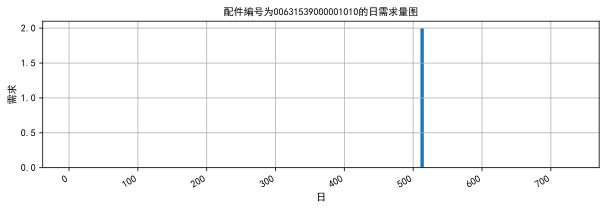

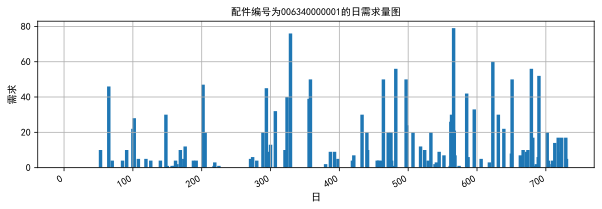

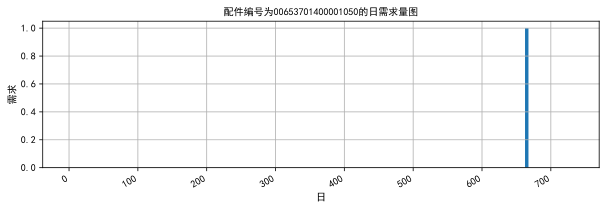

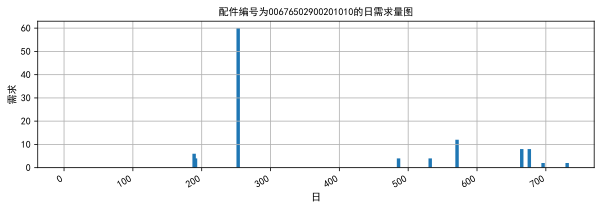

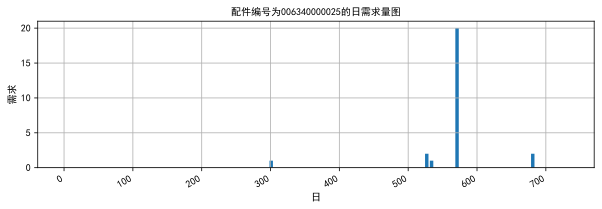

In [17]:
# 取少部分数据，按照日来观察
day_df = df.loc[df['物料类别']=='弹簧件类'].copy()

# 提取该年的第几天
def extract_day(dd):
    dd = datetime.datetime.strptime(dd,"%Y-%m-%d %H:%M:%S")
    return dd.timetuple().tm_yday

# 构造包含完整日的订单数据，没有的日订单数量补0
# 无物料类别信息等业务信息的，补未知
def struct_full_day_df(day_df):
    
    full_day_df = pd.DataFrame(
        product(day_df['物料编号'].unique(), [2020, 2021], range(1,367)), 
        columns=['物料编号', 'year', '年日'])
    drop_index = full_day_df.loc[(full_day_df['year']==2021) & (full_day_df['年日']==366)].index
    full_day_df.drop(drop_index, inplace=True)
    
    temp1 = day_df.groupby(['物料编号', 'year', '年日'], as_index=False)['订单数量'].agg({'日订单数量':'sum'})
    temp2 = day_df.groupby(['物料类别', '物料编号'], as_index=False).count()
    temp3 = day_df.groupby(['基本计量单位', '物料编号'], as_index=False).count()
    temp4 = day_df.groupby(['是否进口件', '物料编号'], as_index=False).count()
    temp5 = day_df.groupby(['周期（天）下计划后的交货周期', '物料编号'], as_index=False).count()
    temp6 = day_df.groupby(['在产情况', '物料编号'], as_index=False).count()
    full_day_df = pd.merge(full_day_df, temp1, on=['物料编号', 'year', '年日'], how='left')
    full_day_df = pd.merge(full_day_df, temp2[['物料类别', '物料编号']], on=['物料编号'], how='left')
    full_day_df = pd.merge(full_day_df, temp3[['基本计量单位', '物料编号']], on=['物料编号'], how='left')
    full_day_df = pd.merge(full_day_df, temp4[['是否进口件', '物料编号']], on=['物料编号'], how='left')
    full_day_df = pd.merge(full_day_df, temp5[['周期（天）下计划后的交货周期', '物料编号']], on=['物料编号'], how='left')
    full_day_df = pd.merge(full_day_df, temp6[['在产情况', '物料编号']], on=['物料编号'], how='left')
    full_day_df['日订单数量'].fillna(0, inplace=True)
    full_day_df.fillna('未知', inplace=True)
    full_day_df['日'] = (full_day_df['year'] - 2020) * 366 + full_day_df['年日']
    return full_day_df

def plot_day(data, ylabel='日订单数量', title='各类配件需求总量日订单量图'):
    
    plt.figure(figsize=(10, 3))
    x = data['日']
    y = data[ylabel]
#     plt.plot(x, y)
    plt.bar(x, y, width=5)
    plt.xticks(fontsize=10)    
    plt.yticks(fontsize=10) 
    plt.xlabel('日', fontsize=10)    
    plt.ylabel('需求', fontsize=10)
    plt.title(title, fontsize=10)
    plt.grid()
    plt.gcf().autofmt_xdate() # 自动旋转日期标记
    plt.show()
    

day_df['年日'] = day_df['创建日期'].apply(extract_day)
matrl_full_day = struct_full_day_df(day_df)
print(len(matrl_full_day))

count = 0
for i in matrl_full_day['物料编号'].unique():
    plot_day(matrl_full_day[matrl_full_day['物料编号']==i],
             ylabel='日订单数量', 
             title='配件编号为'+i+'的日需求量图')
    count += 1
    if count==5:
        break